In [2]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

import os

# https://youtu.be/hraKTseOuJA

"""
Dataset from here: https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html
"""


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
from PIL import Image
import requests
import shutil
import urllib
import math


#Now let us read metadata to get our Y values (multiple lables)
os.chdir("/Users/jonas/Documents/art-classification/")
df = pd.read_csv('data/wikiart_scraped.csv')
print(df.head())     # printing first five rows of the file
print(df.columns)

styles = ["Symbolism", "Expressionism", "Impressionism" ,"Surrealism", "Baroque", "Neoclassicism", "Romanticism", "Realism"]


df = df[df["Style"].isin(styles)]
print(df.iloc[:20])

print(df.shape)

print(df.loc[df["Style"]=="Neoclassicism"])


#save images
image_directory = os.getcwd()+"/data/img/new"
os.chdir(image_directory)

""" Test for a single image
img_url = "https://uploads3.wikiart.org/00265/images/ancient-egyptian-painting/narmer-palette.jpg"
img = Image.open(requests.get(img_url, stream = True).raw)
img = img.resize((300,300))
img.save("bla.jpg")
"""
"""
for index, row in df.iterrows():
    if not os.path.exists(str(index) + ".jpg"):
        img = Image.open(requests.get(row["Link"], stream=True).raw)
        img = img.resize((300, 300))
        img.convert("RGB").save(str(index) + ".jpg")
"""

            Style                                    Artwork         Artist  \
0  Early-Dynastic                             Narmer Palette  Ancient Egypt   
1  Early-Dynastic         Box Inlay with a Geometric Pattern  Ancient Egypt   
2     Old-Kingdom                           Khafre Enthroned  Ancient Egypt   
3  Middle-Kingdom  Stele of the Serpent King (Stela of Djet)  Ancient Egypt   
4  Middle-Kingdom  Laden Donkeys and Ploughing, Tomb of Djar  Ancient Egypt   

           Date                                               Link  
0       3050 BC  https://uploads3.wikiart.org/00265/images/anci...  
1  3100-2900 BC  https://uploads2.wikiart.org/00244/images/anci...  
2       2570 BC  https://uploads2.wikiart.org/00305/images/anci...  
3       3000 BC  https://uploads7.wikiart.org/00305/images/anci...  
4  2060-2010 BC  https://uploads8.wikiart.org/00244/images/anci...  
Index(['Style', 'Artwork', 'Artist', 'Date', 'Link'], dtype='object')
           Style                         

In [38]:
#Need to read images using the tag from metadata.
#Otherwise, if read directly from the folder then images may not correspond to
#the metadata from the csv file.

# use only numeric dates
df = df[df.Date.str.isnumeric()] # only accept numeric dates
df["Date"] = pd.to_numeric(df["Date"])
df = df[df["Date"]>=1000]
timedelta = 10
timesteps = range(1000, 2020, 10)

# bring style to correct format
for style in styles:
    df[style] = 0 #1 if (df["Style"]==style) else 0
    df.loc[df["Style"]==style, style] = 1

# split into decades / other defined timedelta

df["Date"] = df["Date"].apply(lambda x: (math.floor(x/10))*10)


for time in timesteps:
    df[str(time)+"s"]=0

"""
for index, row in df.iterrows():
    found = False
    for time in timesteps:
        if math.floor((row["Date"]/10)*10) == time:
            row[str(time)+"s"] = 1
"""

/var/folders/y5/txmbzvwx3ps9vkrn0gkczm8c0000gn/T/ipykernel_1912/1255388013.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(time)+"s"]=0
/var/folders/y5/txmbzvwx3ps9vkrn0gkczm8c0000gn/T/ipykernel_1912/1255388013.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(time)+"s"]=0
/var/folders/y5/txmbzvwx3ps9vkrn0gkczm8c0000gn/T/ipykernel_1912/1255388013.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

'\nfor index, row in df.iterrows():\n    found = False\n    for time in timesteps:\n        if math.floor((row["Date"]/10)*10) == time:\n            row[str(time)+"s"] = 1\n'

In [39]:

SIZE = 200
X_dataset = []
#for i in tqdm(range(df.shape[0])):
for index, row in df.iterrows():
    img = image.image_utils.load_img(image_directory + "/" + str(index) + '.jpg', target_size=(SIZE,SIZE,3))
    img = image.image_utils.img_to_array(img)
    img = img/255.
    X_dataset.append(img)
    df.loc[index,str(row["Date"])+"s"]=1 # to_categorical would have been the easy solution


X = np.array(X_dataset)

#
print(df.iloc[50])  #Artwork    Penitent Magdalene

print(df.iloc[50]["Style"])  #Tagged as Baroque


#Id and Genre are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.
y = np.array(df.drop(['Style', 'Artwork', 'Artist', 'Date', 'Link'], axis=1))

print(len(X))
print(len(y))


Style                                                Baroque
Artwork                                   Penitent Magdalene
Artist                                            Caravaggio
Date                                                    1590
Link       https://uploads0.wikiart.org/00340/images/cara...
                                 ...                        
1970s                                                      0
1980s                                                      0
1990s                                                      0
2000s                                                      0
2010s                                                      0
Name: 12326, Length: 111, dtype: object
Baroque
10066
10066


In [40]:
import tensorflow as tf

newModel = True
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

if newModel:
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(SIZE,SIZE,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(styles)+len(timesteps), activation='sigmoid')) # changed from 25 to 1 so I get no error

    #Do not use softmax for multilabel classification
    #Softmax is useful for mutually exclusive classes, either cat or dog but not both.
    #Also, softmax outputs all add to 1. So good for multi class problems where each
    #class is given a probability and all add to 1. Highest one wins.

    #Sigmoid outputs probability. Can be used for non-mutually exclusive problems.
    #like multi label, in this example.
    #But, also good for binary mutually exclusive (cat or not cat).

    model.summary()

    #Binary cross entropy of each label. So no really a binary classification problem but
    #Calculating binary cross entropy for each label.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

    # save model
    !mkdir -p saved_model
    model.save('saved_model/my_model_with_years')

else:
    model = keras.models.load_model('saved_model/my_model_with_years')
    #history = model.evaluate(X_test, y_test, verbose=2)
    #history.history=history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 16)      1216      
                                                                 
 batch_normalization (BatchN  (None, 196, 196, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 98, 98, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0

2022-12-07 12:08:57.022991: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


111/111 [==============================] - 86s 766ms/step - loss: 0.2544 - accuracy: 0.0808 - val_loss: 0.0608 - val_accuracy: 0.2891
Epoch 2/10
111/111 [==============================] - 84s 760ms/step - loss: 0.0783 - accuracy: 0.2320 - val_loss: 0.0607 - val_accuracy: 0.3152
Epoch 3/10
111/111 [==============================] - 85s 764ms/step - loss: 0.0673 - accuracy: 0.2699 - val_loss: 0.0580 - val_accuracy: 0.3040
Epoch 4/10
111/111 [==============================] - 86s 778ms/step - loss: 0.0624 - accuracy: 0.3338 - val_loss: 0.0589 - val_accuracy: 0.2907
Epoch 5/10
111/111 [==============================] - 83s 752ms/step - loss: 0.0602 - accuracy: 0.3623 - val_loss: 0.0562 - val_accuracy: 0.3444
Epoch 6/10
111/111 [==============================] - 84s 761ms/step - loss: 0.0585 - accuracy: 0.3863 - val_loss: 0.0560 - val_accuracy: 0.3159
Epoch 7/10
111/111 [==============================] - 84s 760ms/step - loss: 0.0572 - accuracy: 0.4072 - val_loss: 0.0554 - val_accuracy: 0.3

INFO:tensorflow:Assets written to: saved_model/my_model_with_years/assets


INFO:tensorflow:Assets written to: saved_model/my_model_with_years/assets


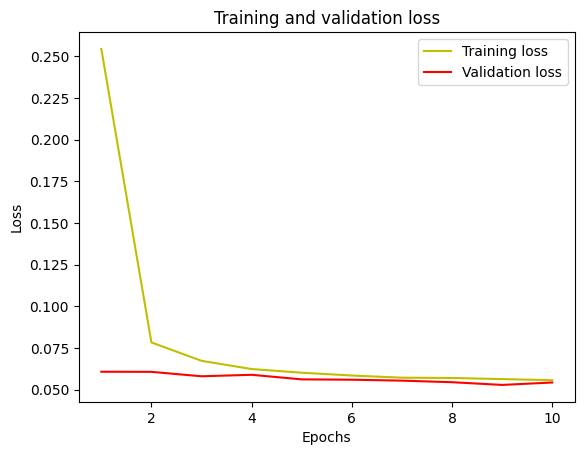

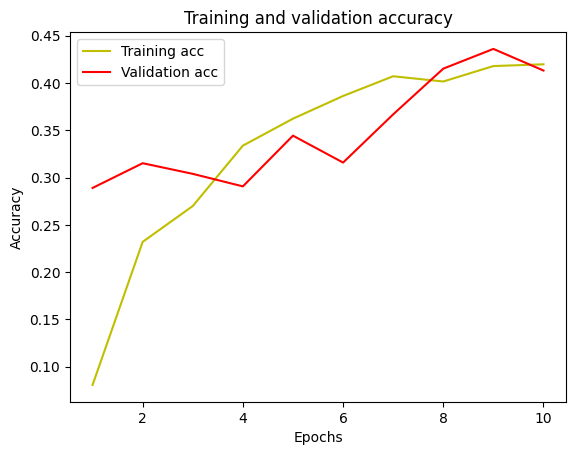

In [41]:


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 0s 13ms/step
Realism (0.409)
Baroque (0.28)
Romanticism (0.248)
1860s (0.138)
1870s (0.129)
1630s (0.109)
1830s (0.092)
1820s (0.0864)
Neoclassicism (0.0616)
1810s (0.0599)


'\n'

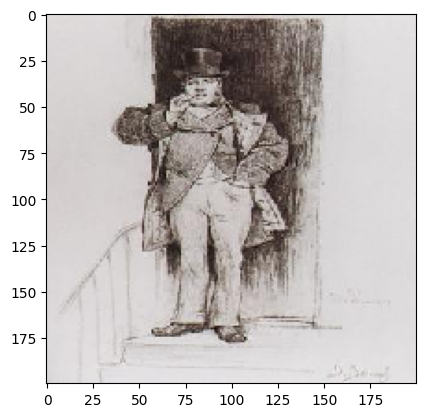

In [70]:
#################################################
#Validate on an image
#img = image.load_img('movie_dataset_multilabel/images/tt4425064.jpg', target_size=(SIZE,SIZE,3))
image_idx = 36300
img = image.image_utils.load_img(str(image_idx)+'.jpg', target_size=(SIZE,SIZE,3))

img = image.image_utils.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(df.columns[5:]) #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories

#Print classes and corresponding probabilities
for i in range(10):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

###################################################

#_, acc = model.evaluate(X_test, y_test)
#print("Accuracy = ", (acc * 100.0), "%")

################################################################

"""
"""





In [69]:
print(df.loc[image_idx,:])

Style                                                Realism
Artwork                          On Nevsky Prospekt at night
Artist                                        Vasily Surikov
Date                                                    1870
Link       https://uploads8.wikiart.org/images/vasily-sur...
                                 ...                        
1970s                                                      0
1980s                                                      0
1990s                                                      0
2000s                                                      0
2010s                                                      0
Name: 36307, Length: 111, dtype: object


In [33]:
print(df.loc[26610,:])

Style                                            Romanticism
Artwork                                 Lady Frances Erskine
Artist                                           David Allan
Date                                                    1760
Link       https://uploads7.wikiart.org/images/david-alla...
                                 ...                        
1970s                                                      0
1980s                                                      0
1990s                                                      0
2000s                                                      0
2010s                                                      0
Name: 26610, Length: 111, dtype: object


In [36]:
print(df.loc[26610, "1760s"])

1
